In [1]:
import os
import pandas as pd
import wfdb
import ast
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
from pprint import pprint
from collections import Counter
import math
from copy import deepcopy

# ============== Scipy
from scipy import signal
from scipy.signal import butter, lfilter, freqz, filtfilt

# ---- PyTorch ---- #
import torch
from torch import nn
from torch import optim
from torch import functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
from torchvision.transforms import ToTensor
from torch.nn.functional import softmax
from torch.nn.parallel import DistributedDataParallel
from pytorchtools import EarlyStopping

# ---- Scikit Learn ---- #
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Normalizer, StandardScaler

# ---- Matplotlib ---- #
import matplotlib.pyplot as plt

# ---- Summary ---- #
import pytorch_model_summary


In [2]:
def load_raw_data(df, sampling_rate, path):
    data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))

In [3]:
sampling_rate = 500

ptb_xl_path = "/data/graduate/ptbxl_103/"

In [4]:
super_class = {}

classes_csv = pd.read_csv(ptb_xl_path+"scp_statements.csv")
classes_csv.rename(columns={"Unnamed: 0":"specific_class"}, inplace=True)
classes_csv["diagnostic_class"] = classes_csv["diagnostic_class"].fillna("OTHERS")

for i in range(len(classes_csv)):
    name = classes_csv.iloc[i].specific_class
    super_c = classes_csv.iloc[i].diagnostic_class
    super_class[name] = super_c

In [5]:
Y = pd.read_csv(ptb_xl_path+"ptbxl_database.csv", index_col="ecg_id")

In [6]:
Y

,patient_id,age,sex,height,weight,nurse,site,device,recording_date,report,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
ecg_id,,,,,,,,,,,,,,,,,,,,,
1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,sinusrhythmus periphere niederspannung,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,sinusbradykardie sonst normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,sinusrhythmus normales ekg,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr
4,17014.0,24.0,0,NaN,82.0,2.0,0.0,CS-12 E,1984-11-15 13:44:57,sinusrhythmus normales ekg,...,True,", II,III,AVF",NaN,NaN,NaN,NaN,NaN,3,records100/00000/00004_lr,records500/00000/00004_hr
5,17448.0,19.0,1,NaN,70.0,2.0,0.0,CS-12 E,1984-11-17 10:43:15,sinusrhythmus normales ekg,...,True,", III,AVR,AVF",NaN,NaN,NaN,NaN,NaN,4,records100/00000/00005_lr,records500/00000/00005_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21833,17180.0,67.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-05-31 09:14:35,ventrikulÄre extrasystole(n) sinustachykardie ...,...,True,NaN,", alles,",NaN,NaN,1ES,NaN,7,records100/21000/21833_lr,records500/21000/21833_hr
21834,20703.0,300.0,0,NaN,NaN,1.0,2.0,AT-60 3,2001-06-05 11:33:39,sinusrhythmus lagetyp normal qrs(t) abnorm ...,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/21000/21834_lr,records500/21000/21834_hr
21835,19311.0,59.0,1,NaN,NaN,1.0,2.0,AT-60 3,2001-06-08 10:30:27,sinusrhythmus lagetyp normal t abnorm in anter...,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,2,records100/21000/21835_lr,records500/21000/21835_hr


In [7]:
class PTBXL(Dataset):
    
    def __init__(self, data_root, 
                folds=[1,2,3,4,5,6,7,8,9,10], 
                class_map = {"NORM":0, "MI":1, "STTC":2, "CD":3, "HYP":4},
                sampling_rate = 500,
                verbose=False,
                transform=None
                ):
        
            self.data_root = data_root
            y = pd.read_csv(os.path.join(self.data_root, 'ptbxl_database.csv'), index_col='ecg_id')
            self.folds = folds
            self.class_map = class_map
            self.sampling_rate = sampling_rate
            self.verbose = verbose
            self.transform = transform

            y = y.loc[y.strat_fold.isin(self.folds)]

             # Load scp_statements.csv for diagnostic aggregation
            agg_df = pd.read_csv(os.path.join(data_root, "scp_statements.csv"), index_col=0)
            self.agg_df = agg_df[agg_df.diagnostic == 1]

            # Apply diagnostic superclass
            y.scp_codes = y.scp_codes.apply(lambda x: ast.literal_eval(x))
            y['diagnostic_superclass'] = y.scp_codes.apply(self.aggregate_diagnostic)

            # Convert to Class numbers
            y["class_ids"] = y.diagnostic_superclass.apply(self.map_class_num)

            self.y = y

            if self.verbose:
                print("unique super classes=", self.agg_df.diagnostic_class.unique())
                print("unique folds=",self.y.strat_fold.unique())
                print(self.agg_df)
                print(self.y.scp_codes)
                print("Class labels=", self.y.diagnostic_superclass)
                print("Class ids=", self.y.class_ids)

    def aggregate_diagnostic(self, y_dic):
        tmp = []
        #print(y_dic)
        for key in y_dic.keys():
            if key in self.agg_df.index:
                tmp.append(self.agg_df.loc[key].diagnostic_class)
        #print("temp =",  tmp)
        return list(set(tmp))

    def map_class_num(self, class_labels):
        temp = []
        try:
            for l in class_labels:
                class_id = self.class_map[l]
                temp.append(class_id)
        except:
            print("These labels are wrong:", class_labels)
        return temp

    def read_row_data(self, data_path):
        signal, meta = wfdb.rdsamp(data_path)
        #data = np.array([signal for signal, meta in data])
        if self.verbose:
            print(signal)
            print(meta)
        return np.array(signal), meta
    
    # Powerline Noise Filtering
    def lowpass_filt(self, fs, low, order=5):
        nyq = 0.5 * fs # 250Hz
    #     lowcut = ((2*low)/fs)
        lowcut = low / nyq
        b, a = butter(order, lowcut, btype="low")
        return b, a

    def powerline_Noise_Filtering(self, fs, low, order, data):
        b, a = self.lowpass_filt(fs, low, order)
        filtered_ecg_data = lfilter(b, a, data)
        return filtered_ecg_data
    
    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):

        y_row = self.y.iloc[idx]
        class_ids = y_row.class_ids

        class_encoded = np.zeros(len(self.class_map))
        class_encoded[class_ids] = 1

        if self.verbose:
            print(class_ids)
            print(class_encoded)

        # To get sample rate 100 ECGs
        if self.sampling_rate == 100:
            data_path = os.path.join(self.data_root, y_row.filename_lr)
            ecg, meta = self.read_row_data(data_path)
        # To get sample rate 500 ECGs
        elif self.sampling_rate == 500:
            data_path = os.path.join(self.data_root, y_row.filename_hr)
            ecg, meta = self.read_row_data(data_path)

        else:
            print("Wrong sample rate")
            exit

        # Get transpose
        #print(ecg.shape)
        ecg = ecg.transpose()
        #print(ecg.shape)
#         ecg = torch.from_numpy(ecg).to(torch.float32)
#         class_encoded = torch.from_numpy(class_encoded).to(torch.float32)

        for lead in range(len(ecg)):
            ecg[lead] = self.powerline_Noise_Filtering(sampling_rate, 45, 5, ecg[lead]) #Powerline Noise Filtering
#         print("ecg_shape=", ecg.shape)
        sample = {"ecg":ecg, "class":class_encoded }
        return sample


In [9]:
data[0]["ecg"].shape

(12, 5000)

In [13]:
record_header = wfdb.rdheader(ptb_xl_path+"records500/00000/00001_hr")
leadNames = record_header.__dict__["sig_name"]
leadNames

['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

STTC 

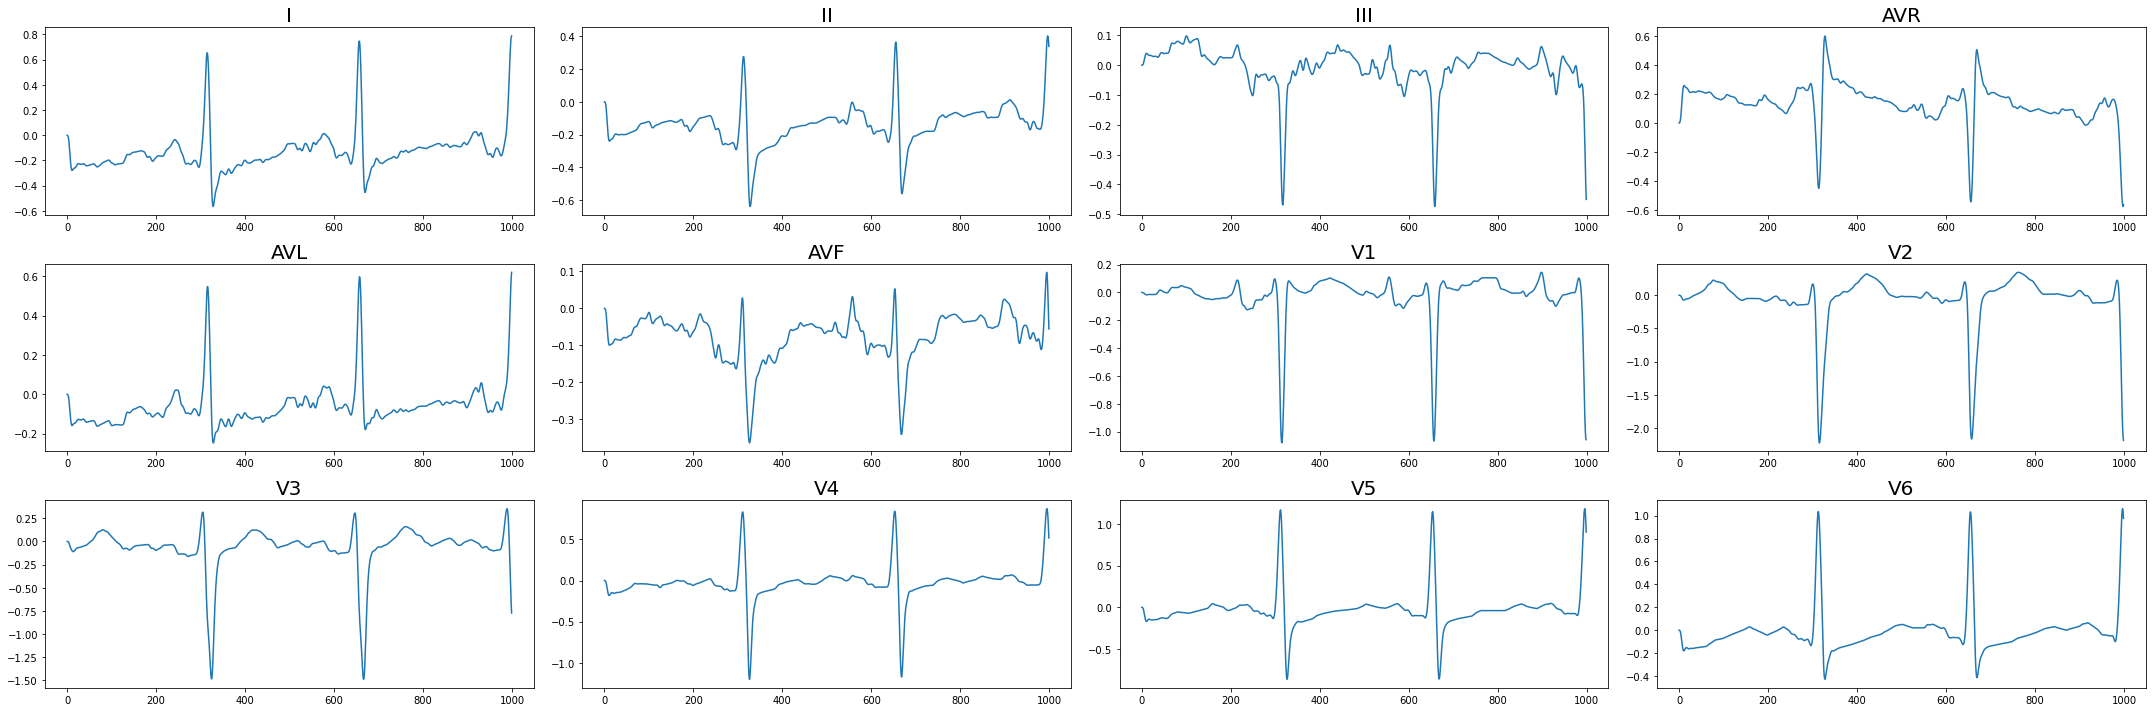

In [14]:
fig = plt.figure(figsize=(30,10))

for i,lead in enumerate(leadNames):
    ax1 = fig.add_subplot(3,4,i+1)
    ax1.set_title(leadNames[i], fontsize=20)
    ax1.plot(data[25]["ecg"][i][0:1000])
fig.tight_layout()

for lab_idx, cl in enumerate(data[25]["class"]):
    if cl == 1:
        print(classes[lab_idx], end=" ")

## EDA

['NORM', 'MI', 'STTC', 'HYP', 'CD']

class_map = {"NORM":0, "MI":1, "STTC":2, "CD":3, "HYP":4}

**Not Filtered**

## Dataloder  

**12-Channel / 500Hz**

In [20]:
from sklearn.model_selection import KFold

kfold = KFold(n_splits=10, shuffle=True)

In [15]:
train_len = int(len(data)-(len(data)*0.2))
# val_len = int(train_len*0.2)
test_len = int(len(data)*0.2)

# print(train_len, val_len, test_len)

In [16]:
x_train = []
y_train = []
x_test = []
y_test = []
for i, d in enumerate(data):
    if i < (train_len):
        ecg = d["ecg"]
        labels = d["class"]
        x_train.append(ecg)
        y_train.append(labels)
    else:
        ecg = d["ecg"]
        labels = d["class"]
        x_test.append(ecg)
        y_test.append(labels)
#     np.append(ecg, x_train)
#     np.append(labels, y_train)

In [24]:
# for 10 Fold
x_train = []
y_train = []
for i, d in enumerate(data):
    ecg = d["ecg"]
    labels = d["class"]
    x_train.append(ecg)
    y_train.append(labels)


In [28]:
x_train_10 = np.array(x_train)
y_train_10 = np.array(y_train)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/x_whole",x_train_10)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/y_whole",y_train_10)

In [17]:
y_train_10.shape

NameError: name 'y_train_10' is not defined

In [18]:
x_train = np.array(x_train)
y_train = np.array(y_train)

# x_valid = np.array(x_valid)
# y_valid = np.array(y_valid)

x_test = np.array(x_test)
y_test = np.array(y_test)

#### Train / Validation / Test Data Portion

6 : 2 : 2

In [20]:
np.save("/data/graduate/MI_Detection_Transformer/npy_data/x_train_103",x_train)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/y_train_103",y_train)
# np.save("/data/graduate/MI_Detection_Transformer/npy_data/x_valid",x_valid)
# np.save("/data/graduate/MI_Detection_Transformer/npy_data/y_valid",y_valid)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/x_test_103",x_test)
np.save("/data/graduate/MI_Detection_Transformer/npy_data/y_test_103",y_test)

In [19]:
print(x_train.shape,",",y_train.shape)
# print(x_valid.shape,",",y_valid.shape)
print(x_test.shape,",",y_test.shape)

(17439, 12, 5000) , (17439, 5)
(4360, 12, 5000) , (4360, 5)


In [22]:
def get_DataLoader(x, y, batch, num_workers):
    x_tensor = torch.FloatTensor(x)
    y_tensor = torch.FloatTensor(y)
    dataset = TensorDataset(x_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=False)
    return dataloader

In [36]:
batch_size = 32
num_workers = 2

train_loader = get_DataLoader(x_train, y_train, batch=32, num_workers=num_workers)
val_loader = get_DataLoader(x_valid, y_valid, batch=16, num_workers=num_workers)
test_loader = get_DataLoader(x_test, y_test, batch=32, num_workers=num_workers)

## Build Model Architecture

Anomaly Classification using Transformer  

CNN + Transformer는 어떤가?... 대신 CNN은 Depthwise Separable Convolution(DSC)을 써야하는게 아닐까 싶음 - 하나의 Feature를 뽑아냄

DSC

ViT Patch Size를 각각의 리드로 하면 어떨까? 그대신 근데 문제가 있는게, 일단 Flatten을 할필요가 없긴함  
--> ViT 자체가 저해상도의 이미지를 이야기하다보니..

https://yonigottesman.github.io/ecg/vit/deep-learning/2023/01/20/ecg-vit.html Tensorflow to pytorch